# <center>Similarity Test</center>

This notebook will read in a MIDI file generated and a directory of MIDI files that it learned on and will determine the similarity of it to each of the songs.

It was created to refute our hypothesis that the model was simply copying sections of other midis in the set rather than creating it's own unique music. We needed to check this automatically as it is impractical to search through several hundreds of songs to confirm it manually.

## Directions for Use

1. Place the desired MIDI file in the folder /Similarity/input
2. Place the training MIDIs into the folder /Similarity/compare_to
3. Run all code snippets
4. The final code snippet will output the percentage the input song matches the comparison songs

In [4]:
import glob
from music21 import converter, instrument, note, chord, stream, duration
from fuzzywuzzy import fuzz
import numpy as np
import pandas as pd

C:\Users\Michael\Anaconda3\envs\CITS4404\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


First, get all of the notes for the songs to compare the input to.

In [5]:
def get_notes(path):
    """
        Gets all notes and chords from midi file
    """
    notes = []
    names = []

    for file in glob.glob(path + "*.mid"):        
        song = []
        midi = converter.parse(file)
        
        # Get some info about the file
        key = midi.analyze('key')
        key_string = key.tonic.name + ' ' + key.mode
        
        print("Parsing %s" % file)
        print(key_string)
        
        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                song.append([str(element.pitch), element.offset, element.duration])
            elif isinstance(element, chord.Chord):
                song_note = '.'.join(str(n) for n in element.normalOrder)
                song.append([song_note, element.offset, element.duration])
        notes.append(np.array(song))
        names.append(file.strip(path + '\\'))

    return notes, names

comp_path = "../Similarity/compare_to/"
comp_notes, comp_names = get_notes(comp_path)

Parsing ../Similarity/compare_to\Pokemon Gold, Silver, Crystal - Cinnabar Island (HGSS Version).mid
G major
Parsing ../Similarity/compare_to\Pokemon Gold, Silver, Crystal - S.S. Aqua .mid
G major
Parsing ../Similarity/compare_to\Pokemon GoldSilverCrystal - Azalea TownBlackthorn City.mid
C# major
Parsing ../Similarity/compare_to\Pokemon GoldSilverCrystal - Bicycle.mid
E minor
Parsing ../Similarity/compare_to\Pokemon GoldSilverCrystal - Bug Catching Contest.mid
E minor
Parsing ../Similarity/compare_to\Pokemon GoldSilverCrystal - Burned Tower.mid
E minor
Parsing ../Similarity/compare_to\Pokemon GoldSilverCrystal - Champion Battle.mid
G# minor
Parsing ../Similarity/compare_to\Pokemon GoldSilverCrystal - Cherrygrove CityMahogany Town.mid
F major
Parsing ../Similarity/compare_to\Pokemon GoldSilverCrystal - Dance Theatre.mid
A minor
Parsing ../Similarity/compare_to\Pokemon GoldSilverCrystal - Dark Cave.mid
A- major
Parsing ../Similarity/compare_to\Pokemon GoldSilverCrystal - Dragons Den.mid
C

Process the similarities into readable formats

In [6]:
sep = " "
comp_pitches = []
comp_offsets = []
comp_durations = []
for song in comp_notes:
    if len(song):
        comp_pitches.append(sep.join(song[:,0]))
        comp_offsets.append(sep.join([str(round(float(x), 2)) for x in song[:,1]]))
        comp_durations.append(sep.join([str(round(float(x.quarterLength), 2)) for x in song[:,2]]))

Next, get the input song. This is assumed to be the first song received.

In [7]:
input_path = "../Similarity/input/"
notes, names = get_notes(input_path)

Parsing ../Similarity/input\Pokemon_GSC_3.mid
A- major


In [8]:
input_notes = notes[0]
input_name = names[0]

Process the input song

In [9]:
sep = " "
input_pitches = sep.join(input_notes[:,0])
input_offsets = sep.join([str(round(float(x), 2)) for x in input_notes[:,1]])
input_durations = sep.join([str(round(float(x.quarterLength), 2)) for x in input_notes[:,2]])

Now, the fuzz library is used to test the similarity of songs. It considers pitch, offset and duration as equally weighted so the similarity score is considered to be the weighted average of the three.

In this case, a partial ratio is implemented because this considers the similarity of sentences, rather than exact words. Many of the elements are expected to be copied over from the songs, so simply counting how many are used in both is too basic to compare realistically.<br>
This is the best measure for music because it allows for the same notes to be played with other notes in between without penalization in score, which is what would be desired - sounding similar, while trying new things.

They are then presented in descending order.

In [10]:
similarity_scores = dict()
for (comp_pitch, comp_offset, comp_duration, name) in zip(comp_pitches, comp_offsets, comp_durations, comp_names):
    similarity_scores[name] = round((fuzz.partial_ratio(input_pitches, comp_pitch) + fuzz.partial_ratio(input_offsets, comp_offset) + fuzz.partial_ratio(input_durations, comp_duration))/3, 2)

In [11]:
import operator
sorted_similarity_scores = sorted(similarity_scores.items(), key=operator.itemgetter(1), reverse=True)
print('Similary Score (%)  -      Song Name')
for tup in sorted_similarity_scores:
    print(f'{tup[1]:.2f}                -     {tup[0]}')

Similary Score (%)  -      Song Name
6.67                -     Pokemon GoldSilverCrystal - Goldenrod City.mid
6.33                -     Pokemon HeartGoldSoulSilver - Game Corner.mid
5.67                -     Pokemon GoldSilverCrystal - Saffron City.mid
3.67                -     Pokemon HeartGoldSoulSilver - Safari Zone Gate.mid
2.00                -     Pokemon Gold, Silver, Crystal - Cinnabar Island (HGSS Version).mid
2.00                -     Pokemon GoldSilverCrystal - Champion Battle.mid
2.00                -     Pokemon GoldSilverCrystal - Girl Trainer Confrontation.mid
2.00                -     Pokemon GoldSilverCrystal - Sprout Tower.mid
2.00                -     Pokemon HeartGoldSoulSilver - Cinnabar Island.mid
1.67                -     Pokemon GoldSilverCrystal - Gym.mid
1.67                -     Pokemon GoldSilverCrystal - Lavender Town.mid
1.67                -     Pokemon GoldSilverCrystal - Pokemon March.mid
1.67                -     Pokemon GoldSilverCrystal - Victory Roa

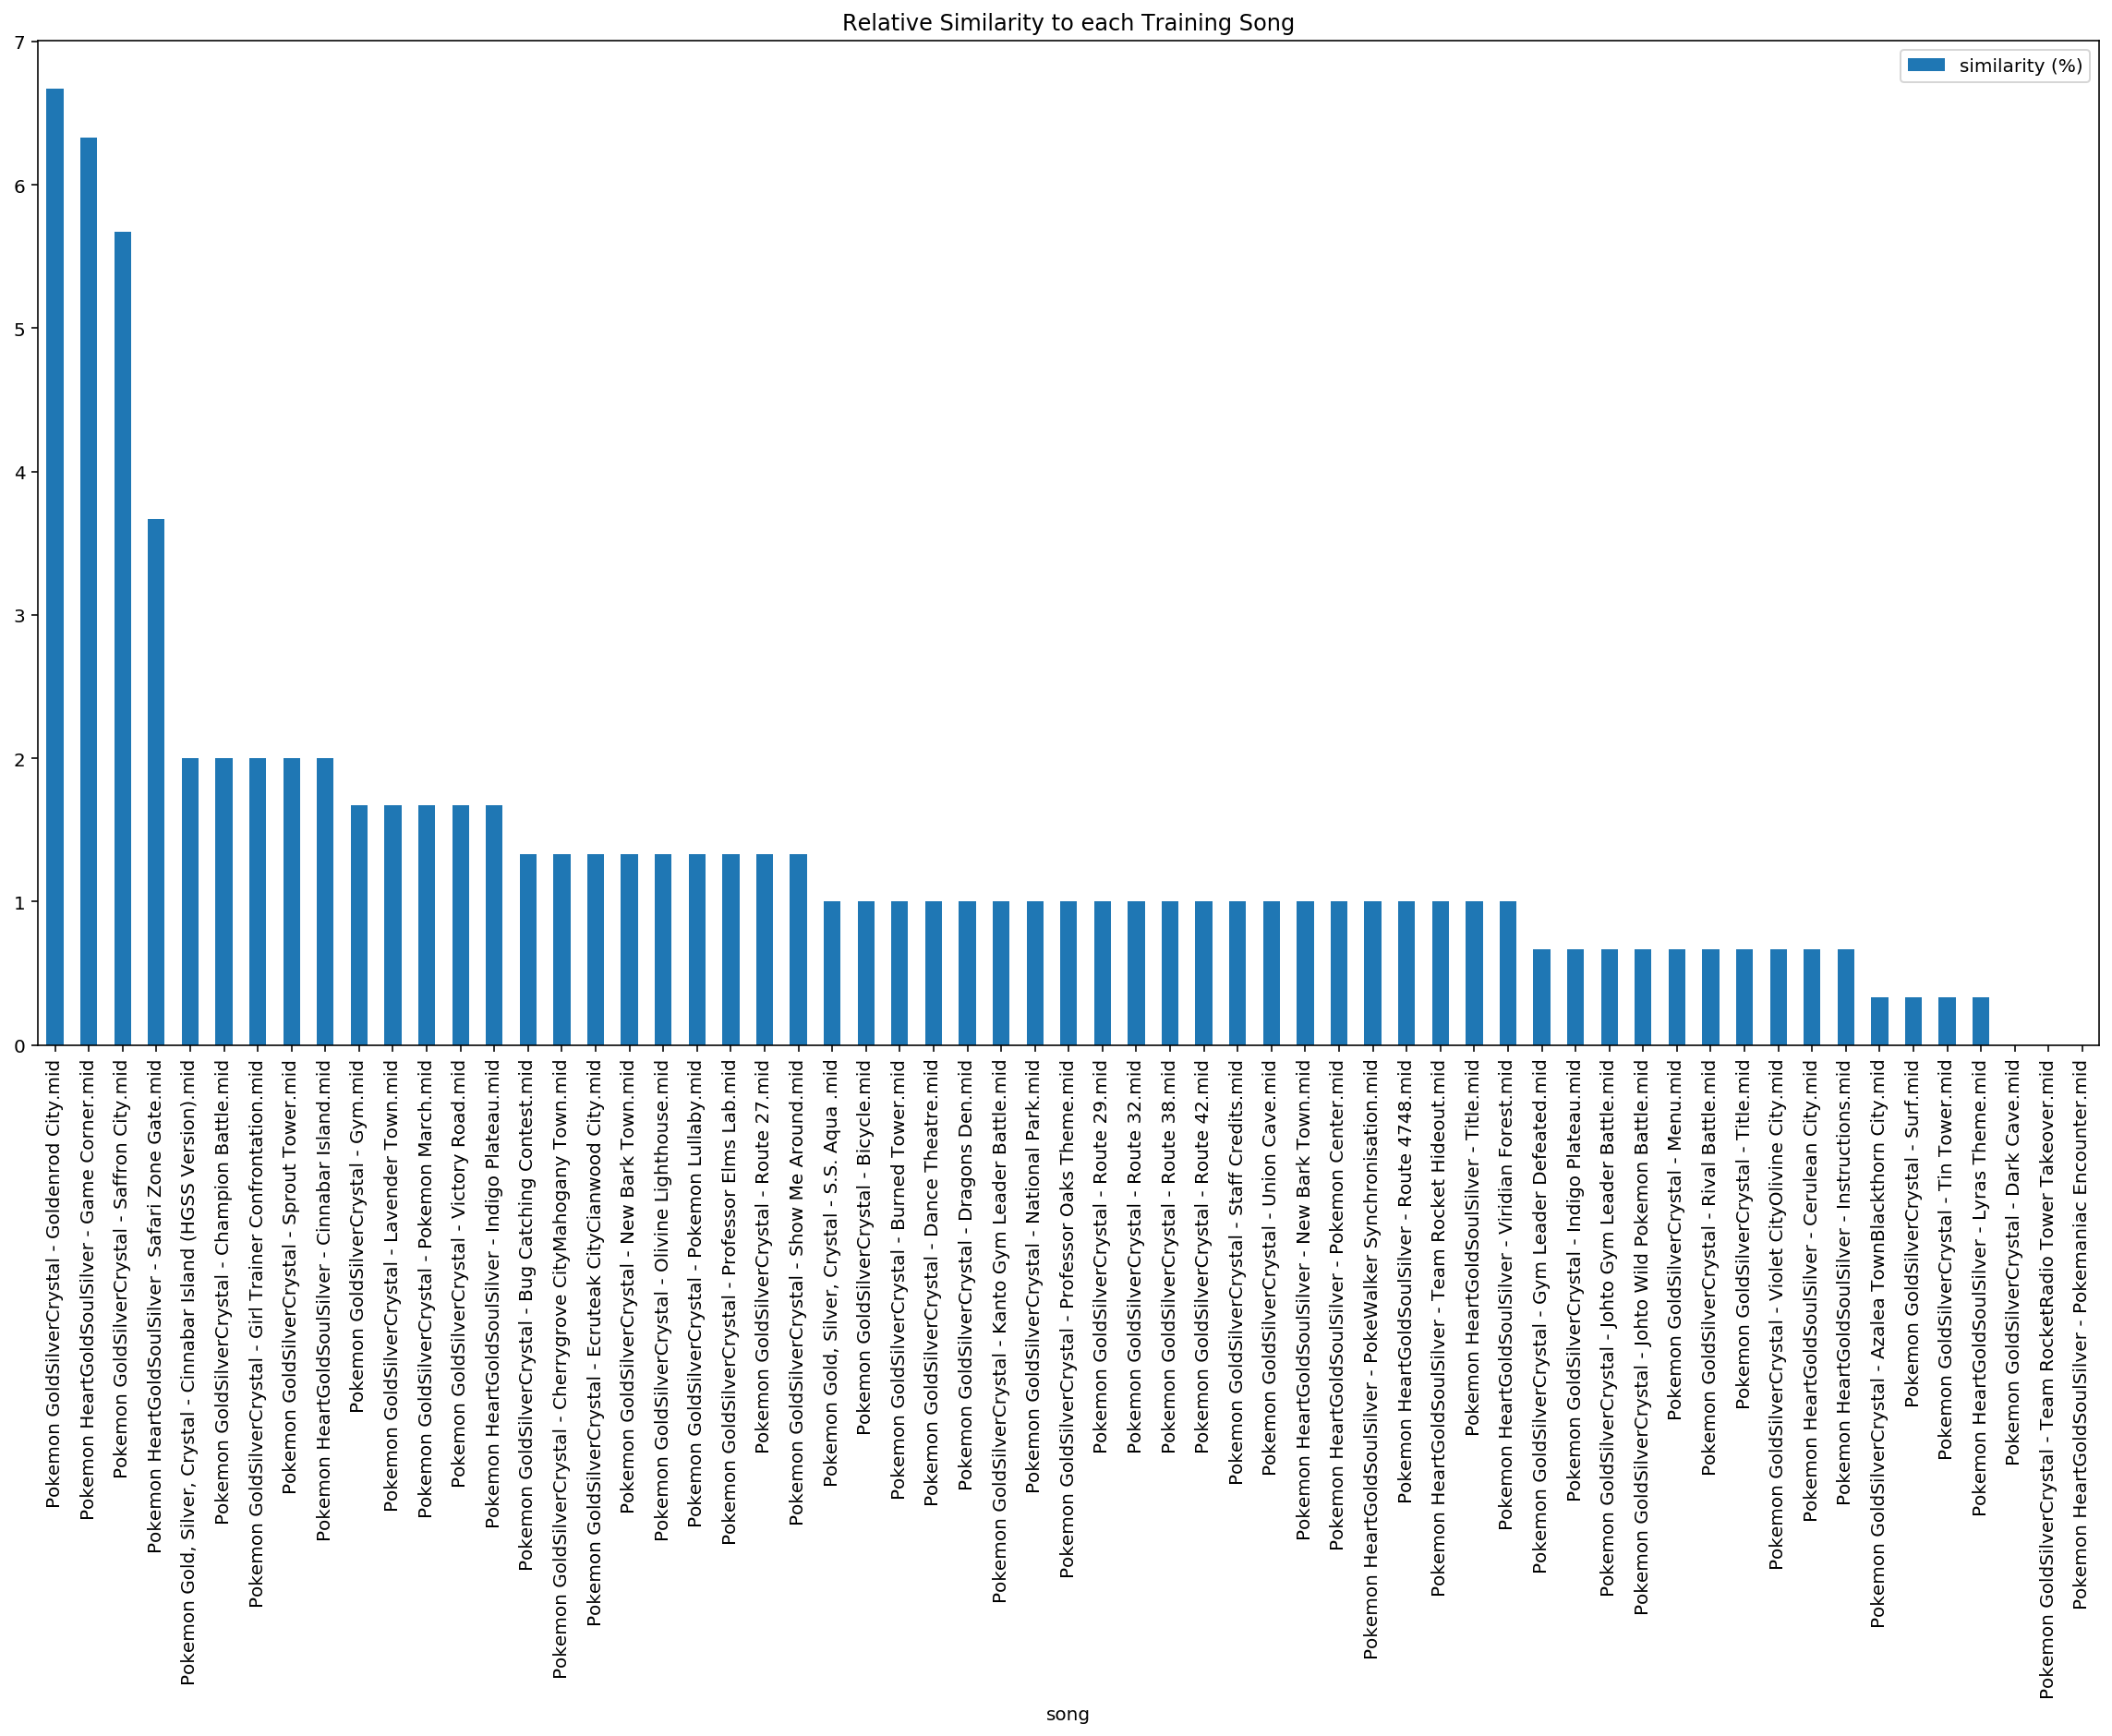

In [18]:
df = pd.DataFrame(sorted_similarity_scores, columns=['song', 'similarity (%)'])
df.plot(kind='bar', x='song', figsize=(20,10), title='Relative Similarity to each Training Song')

## Conclusion

After running this similatiy test for several of our output tracks, we observed small enough scores to conclude that there is negledgable overfitting by our generated midi files. At most, there was 10-15% similarity with, most tracks scoring under 2%. These results confirm that our RNN model does infact learn to create unique midi tracks which sound similar to the set provided.

However, we did note very high overfitting with some other datasets e.g. the full Pokemon or LoZ dataset of up to 60%. This is assumed to be due to overtraining as we found this became less of a problem as we went back several checkpoints. This demonstrates the use of this notebook.

Future work could incorporate this measurement along with loss to attempt to train a model that avoids overfitting while trying to minimize loss.